In [61]:
!del v1.docx && pandoc "Image Classification using Tensorflow.ipynb" -s -o Image_classification_using_Tensorlfow.docx

# Image Classification using Tensorflow

## What is image classification ?

Let's start by defining what image classification is. Image classification is the task of identifying and assigning a particular label to an image. In our daily lives we are able to recognize and identify various images/objects through our eyes, this is an example of image classification as done by our eyes and the brain. Question is can we use the computer to do it for us automatically ? All we will provide the computer with is an image and it has to tell us what the image is about and assign it a label. The answer is a resounding YES! In fact,  this has been an active area of research for a long time now. 

You may ask me but what's the point of classifying an image automatically ? Where can it be useful ? You have a valid question. Let me motivate you with some examples.

## Applications of image classification

1. Quality Management
In the industry, we have computer vision systems which click pictures of various parts and identify the defective parts from the rest. This is particularly useful as manual inspection of thousands of parts is very time consuming, less cost effective and does not scale

2. Cancer detection:
Image recognition helps in detecting differences between cancerous and non - cancerous cells. This helps in further diagnosis of the disease

3. Masked face recognition
Image recognition can be used to detect people wearing or not wearing masks to limit the spread of coronavirus. 

4. Brain tumor detection
Brain tumor in MRI scans is detected using CNNs

5. Smart farmining
Animal monitoring can be done using computer vision systems. This is an integral component of smart farming




With this motivation in mind, let's see how we can do image classification using deep learning. We will be using Tensorflow as our framework to illustarte this.

All the imports we will need

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

## Dataset

### Downloading the dataset and splitting it

We will be using imagenette. It's a smaller version of the oroginal imagenet dataset containing just 10 classes.

This dataset can be downloaded manually. But we will be using tensorflow datasets to load it. The reason is tensorflow datasets come with a lot of utilities. All the datasets downloaded using tfds are already tensorlfow satasets which can use all of existing tensorlfow functions and especially `tf.data` a powerful input pipeline

In [12]:
data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)

In [13]:
data

{'train': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'validation': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

The dataset is already split in to training and validation sets for us. No need for us to manually do it. So, let's just separate the two splits

In [14]:
train_ds = data['train']
val_ds = data['validation']

Now, let's look at how we can extract other essential information regarding the dataset like the class name etc.
You can see the all tfds datasets come with metadata, we can leverage this to get the required informaiton

In [15]:
info

tfds.core.DatasetInfo(
    name='imagenette',
    full_name='imagenette/160px-v2/1.0.0',
    description="""
    Imagenette is a subset of 10 easily classified classes from the Imagenet
    dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
    behind putting together a small version of the Imagenet dataset was mainly
    because running new ideas/algorithms/experiments on the whole Imagenet take a
    lot of time.
    
    This version of the dataset allows researchers/practitioners to quickly try out
    ideas and share with others. The dataset comes in three variants:
    
      * Full size
      * 320 px
      * 160 px
    
    Note: The v2 config correspond to the new 70/30 train/valid split (released
    in Dec 6 2019).
    """,
    config_description="""
    160px variant.
    """,
    homepage='https://github.com/fastai/imagenette',
    data_path='C:\\Users\\abhi0\\tensorflow_datasets\\imagenette\\160px-v2\\1.0.0',
    download_size=94.42 MiB,
    dat

First we will extract the class names, and number of classes

In [16]:
label_info = info.features['label']

In [17]:
label_info

ClassLabel(shape=(), dtype=tf.int64, num_classes=10)

This is an instance of `ClassLabel` class and comes with it's own set of methods

In [18]:
print(f"The number of classes is: {label_info.num_classes}")

The number of classes is: 10


In [19]:
print(f"The label names are: {label_info.names}")

The label names are: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


The labels don't really make much sense if you look at them. However, when you read up about imagenet dataset online, you can find the human readable names these numbers map to. Let's make a lookup table we can use to convert them back and forth

In [20]:
label2name = {
    "n01440764": "tench", 
    "n02102040": "English springer", 
    "n02979186": "cassette player", 
    "n03000684": "chain saw", 
    "n03028079": "church", 
    "n03394916": "French horn", 
    "n03417042": "garbage truck",
    "n03425413": "gas pump", 
    "n03445777": "golf ball", 
    "n03888257": "parachute"
}

In [21]:
class_names = [label2name[name] for name in label_info.names]

Let's look at a single image and it's label

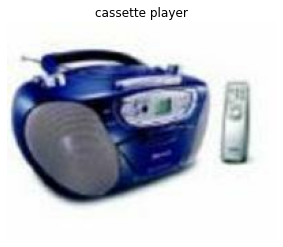

In [22]:
image, label = next(iter(train_ds))
_ = plt.imshow(image.numpy().astype("uint8"))
_ = plt.title(label2name[label_info.int2str(label)])
_ = plt.axis("off")

## The Input pipepline

### Preparing the data

We now have the dataset with us, along with the coressponding label. We have also split the dataset up into training and validation. 

Next we need to prepare our data to be fed into the model for training. 

First we resize all the images into 150 x 150, then batch them, followed by augmenting the images. Finally we optimize for performance 

We start with resizing and augmentations

Since our dataset is a tensorflow dataset we can use `map` function to resize our images. This is very simple, fast and efficient as we don't have to iterate over all the images one by one and resize them.

In [23]:
train_ds = train_ds.map(
    lambda x, y: (tf.image.resize(x, size=(150, 150)), y)
).batch(16)

val_ds = val_ds.map(
    lambda x, y: (tf.image.resize(x, size=(150, 150)), y)
).batch(16)

We now apply some basic augmentations to our images. Augmentations help in increasing the robustness of the model

In [24]:
def augment_image(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.rot90(images)
    
    return images, labels

In [25]:
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

Let's see how these augmentations look on a single image

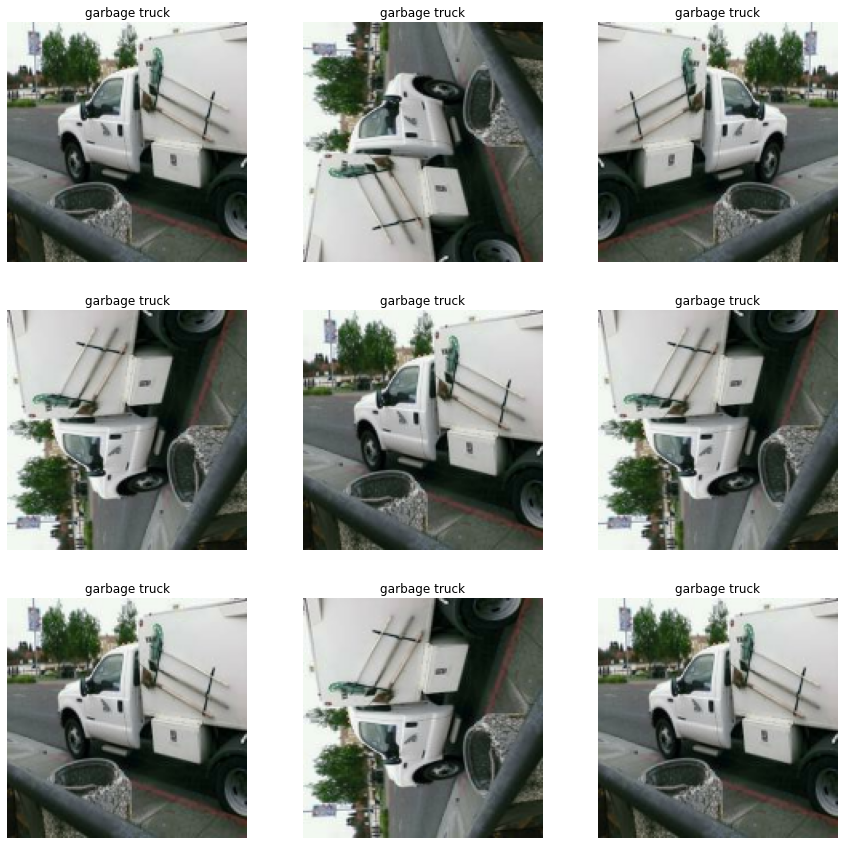

In [26]:
images, labels = next(iter(train_ds))
img = images[1]
lbl = labels[1]

plt.figure(figsize=(15, 15))
for i in range(9):
    img, lbl = augment_image(img, lbl)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(label2name[label_info.int2str(lbl)])
    plt.axis("off")

Let's have a look at few of the images and their labels

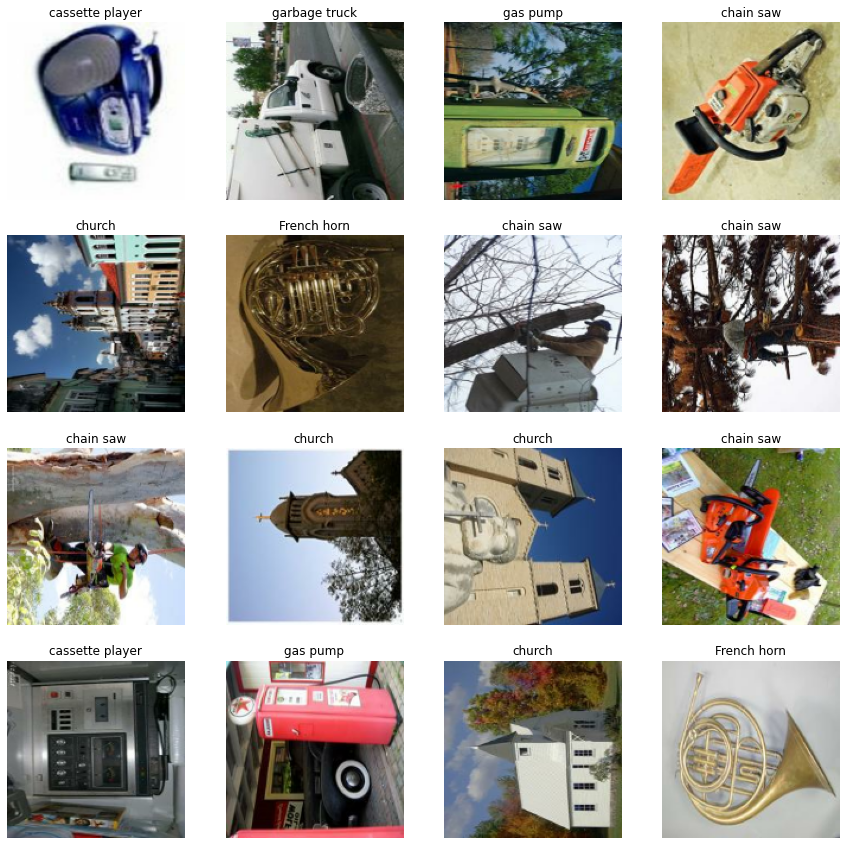

In [27]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label2name[label_info.int2str(labels[i])])
        plt.axis("off")

### Optimizing for performance

`Dataset.cache` caches the images and the subsequent runs will use these images and not always go and fetch them from the secondary memory. 

`Dataset.prefetch` overlaps data preprocessing and model execution while training. While the model is training in epoch `n` it parellelly prepares the data for epoch `n+1`

We can use `tf.data.AUTOTUNE` to automatically select tuning parameters for cache and prefetch

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Modelling

We start by creating a simple model consisting of only `Dense` layers. We will slowly move on to using `Conv` layers

In [29]:
num_classes = 10

model_1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

You can see that I have added Rescaling as the first layer. It rescales all the image values to be between 0 and 1.
Now you may ask that we could have also done rescaling while we were preparing the data and resizing it. You have a valid point we can also do it that way. My reason for including it in the model logic is that while the model is training the images are being rescaled on the fly. We can leverage our GPU to do Rescale the images.  

Our model is a very simple model consisting of only 1 hidden layer. Naturally, we should not expect it be as robust. But, this is done just to demonstarte to u, a very basic baseline model

## Optimizer, loss and metrics

We now need to specify an optimizer, this will be used to update the weights. We take the simplest one called `sgd`

For loss, since this is a multiclass classification problem. We take the loss to be `SparseCategoricalCrossentropy`

We will use `accuracy` as our metric. It's quite simple and good enough since our dataset is not imbalanced

In [21]:
model_1.compile(
  optimizer='sgd',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [22]:
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
296/296 [==============================] - 8s 23ms/step - loss: 2.3985 - accuracy: 0.1224 - val_loss: 2.2557 - val_accuracy: 0.1715
Epoch 2/10
296/296 [==============================] - 3s 8ms/step - loss: 2.1792 - accuracy: 0.2097 - val_loss: 2.2278 - val_accuracy: 0.1847
Epoch 3/10
296/296 [==============================] - 3s 9ms/step - loss: 2.1381 - accuracy: 0.2298 - val_loss: 2.2065 - val_accuracy: 0.1931
Epoch 4/10
296/296 [==============================] - 3s 8ms/step - loss: 2.1114 - accuracy: 0.2413 - val_loss: 2.1926 - val_accuracy: 0.1995
Epoch 5/10
296/296 [==============================] - 3s 8ms/step - loss: 2.0667 - accuracy: 0.2492 - val_loss: 2.1326 - val_accuracy: 0.2181
Epoch 6/10
296/296 [==============================] - 3s 8ms/step - loss: 1.9952 - accuracy: 0.2701 - val_loss: 2.1082 - val_accuracy: 0.2316
Epoch 7/10
296/296 [==============================] - 3s 8ms/step - loss: 1.9628 - accuracy: 0.2883 - val_loss: 2.0989 - val_accuracy: 0.2341
Epoch

## Plotting

All the information regarding our training are returned as a dictionary by keras. We can use this to plot traning and validation loss

In [23]:
history

In [24]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [25]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

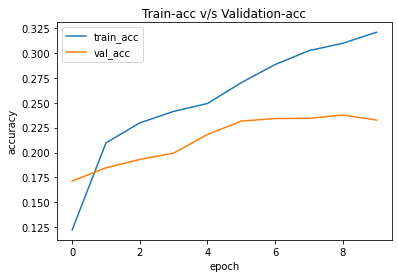

In [26]:
plt.title("Train-acc v/s Validation-acc")
plt.plot(history.epoch, train_acc)
plt.plot(history.epoch, val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
_ = plt.legend(['train_acc', 'val_acc'])

As you can see that training accuracy is getting better, but the validation accuracy has gone haywire. Our simple model is overfitting to the data. This is expected as it's too simple and just has a single hidden layer

## Improving our model

Our baseline model had on Dense layers. Now let's introduce some Conv layers along with non-linear activations

In [27]:
model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ]
)

In [28]:
model_2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [29]:
history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
296/296 [==============================] - 16s 43ms/step - loss: 3.8944 - accuracy: 0.3564 - val_loss: 1.9350 - val_accuracy: 0.3210
Epoch 2/10
296/296 [==============================] - 12s 40ms/step - loss: 1.3809 - accuracy: 0.5388 - val_loss: 1.9708 - val_accuracy: 0.3585
Epoch 3/10
296/296 [==============================] - 12s 40ms/step - loss: 1.0926 - accuracy: 0.6315 - val_loss: 2.5073 - val_accuracy: 0.3343
Epoch 4/10
296/296 [==============================] - 12s 40ms/step - loss: 0.8322 - accuracy: 0.7278 - val_loss: 2.5715 - val_accuracy: 0.3088
Epoch 5/10
296/296 [==============================] - 12s 40ms/step - loss: 0.6501 - accuracy: 0.7831 - val_loss: 3.2485 - val_accuracy: 0.2950
Epoch 6/10
296/296 [==============================] - 12s 40ms/step - loss: 0.5020 - accuracy: 0.8334 - val_loss: 3.8096 - val_accuracy: 0.2943
Epoch 7/10
296/296 [==============================] - 12s 40ms/step - loss: 0.4600 - accuracy: 0.8474 - val_loss: 3.8873 - val_accuracy:

In [30]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

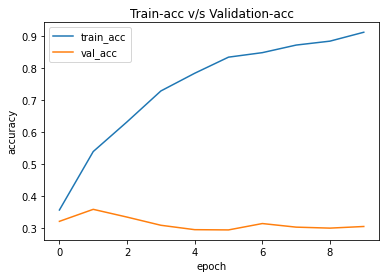

In [31]:
plt.title("Train-acc v/s Validation-acc")
plt.plot(history.epoch, train_acc)
plt.plot(history.epoch, val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
_ = plt.legend(['train_acc', 'val_acc'])

The training accuracy has gone up to 91 % however the validation accuracy is just 32 %. The model is heavily over fitting the data. We need a lot more improvement  

This is where we can use transfer learning. 

## Transfer learning

In transfer learning we use a model trainied on a one task as a base model for training another model for a different task

Let us see how it's done in tensorflow

We will use `resnet50` as our base model

In [30]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [31]:
base_model.trainable = False

In [32]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10)(x)
model_3 = tf.keras.Model(inputs, outputs)

In [33]:
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [34]:
model_3.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [35]:
hist = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/5
592/592 [==============================] - 70s 113ms/step - loss: 0.6023 - accuracy: 0.8101 - val_loss: 0.6056 - val_accuracy: 0.8066
Epoch 2/5
592/592 [==============================] - 60s 102ms/step - loss: 0.3354 - accuracy: 0.8948 - val_loss: 0.6171 - val_accuracy: 0.8082
Epoch 3/5
592/592 [==============================] - 62s 105ms/step - loss: 0.2431 - accuracy: 0.9234 - val_loss: 0.6684 - val_accuracy: 0.8031
Epoch 4/5
592/592 [==============================] - 62s 104ms/step - loss: 0.1834 - accuracy: 0.9433 - val_loss: 0.7032 - val_accuracy: 0.8018
Epoch 5/5
592/592 [==============================] - 61s 104ms/step - loss: 0.1418 - accuracy: 0.9610 - val_loss: 0.7245 - val_accuracy: 0.8031


In [36]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

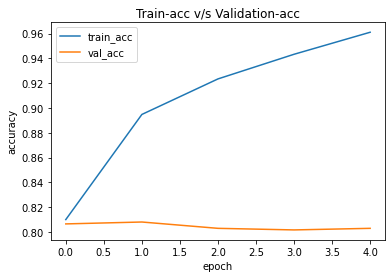

In [37]:
plt.title("Train-acc v/s Validation-acc")
plt.plot(hist.epoch, train_acc)
plt.plot(hist.epoch, val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
_ = plt.legend(['train_acc', 'val_acc'])

You can see we are doing considerably well. And all we have done is train the model just for 5 epochs without any other special tricks in the book. 
The validation accuracy is gone upto 84 %. While the there's still a lot of disparity between training and validation accuracy but we havent't done any hyperparameter tuning so that's good for starters

## Saving models

This is our best model, lets save it so that we can use it for deployment or testing later 

In [41]:
model_3.save("best_model")

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets
C:\Users\abhi0\anaconda3\envs\abhishek\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


The model is now saved in the **TensorFlow SavedModel format**. Now let's test it a real image

In [7]:
idx2label = {
    0: "tench", 
    1: "English springer", 
    2: "cassette player", 
    3: "chain saw", 
    4: "church", 
    5: "French horn", 
    6: "garbage truck",
    7: "gas pump", 
    8: "golf ball", 
    9: "parachute"
}

This is the image we are gonna use for testing. This is a **tench**. Let's see if out model can predict it right

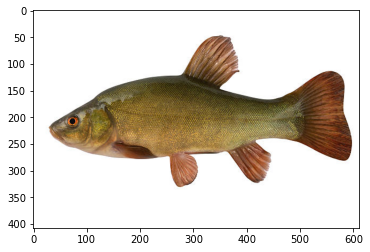

In [57]:
_ = plt.imshow(Image.open('tench.jpg'))

In [58]:
def predict(image_name):
    image = tf.io.read_file(image_name)
    image = tf.io.decode_image(image)
    image = tf.image.resize(image, (150, 150))
    batch = tf.expand_dims(image, 0)
    res = model_3(batch)
    return idx2label[tf.argmax(res[0]).numpy()]

In [60]:
predict('tench.jpg')

'tench'

Awesome! We now have a model which can detect 10 different classes of the original imagenet dataset!

Now you're ready to train your own deep learning models! 

In [2]:
best_model = tf.keras.models.load_model("best_model")

In [11]:
image = tf.io.read_file('test.jpg')
image = tf.io.decode_image(image)
image = tf.image.resize(image, (150, 150))
batch = tf.expand_dims(image, 0)
res = best_model.predict(batch)
print(f"It's a: {idx2label[tf.argmax(res[0]).numpy()]}")

It's a: English springer
